In [1]:
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
pd.set_option("display.max_rows", None)  # 모든 행 출력
pd.set_option("display.max_columns", None)  # 모든 열 출력
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import os
from itertools import product
from functions import (load_parameters, load_generation_data, load_price_data, generate_randomized_generation,
generate_rt_scenarios, plot_generation_data, plot_randomized_generation, plot_scenarios_for_generator, plot_rt_scenarios, plot_summary)

generation_data, I, T = load_generation_data(date_filter="2022-07-18")
S, R, P_RT, K, K0, M1, M2 = load_parameters(I, T, generation_data)
P_DA, P_PN = load_price_data()

✅ 총 5개 파일을 불러왔습니다: 1201.csv, 137.csv, 401.csv, 524.csv, 89.csv
📊 데이터 Shape: I=5, T=24, S=50
✅ 시뮬레이션 초기화 완료: S=50, Randomness='high', M1=760.00, M2=2196.00


In [2]:
agg = gp.Model("agg")
agg.setParam("OutputFlag", 0)
agg.setParam("MIPGap", 1e-7)

a = agg.addVars(T, vtype=GRB.CONTINUOUS, name="alpha")
bp = agg.addVars(T, S, vtype=GRB.CONTINUOUS, name="beta_plus")
bm = agg.addVars(T, S, vtype=GRB.CONTINUOUS, name="beta_minus")
g = agg.addVars(T+1, S, vtype=GRB.CONTINUOUS, name="gamma")
gc = agg.addVars(T, S, vtype=GRB.CONTINUOUS, name="gamma_charge")
gd = agg.addVars(T, S, vtype=GRB.CONTINUOUS, name="gamma_discharge")
eta = agg.addVars(T, S, vtype=GRB.BINARY, name="eta")
lam = agg.addVars(T, S, vtype=GRB.BINARY, name="lambda")
mu = agg.addVars(T, S, vtype=GRB.BINARY, name="mu")

agg.update()

obj = gp.quicksum(P_DA[t] * a[t] for t in range(T)) + \
      gp.quicksum(1 / S * (P_RT[t, s] * bp[t, s] - P_PN[t] * bm[t, s])
                  for t, s in product(range(T), range(S)))

agg.setObjective(obj, GRB.MAXIMIZE)

for t, s in product(range(T), range(S)):
    agg.addConstr(gp.quicksum(R[i, t, s] for i in range(I)) - a[t] == bp[t, s] - bm[t, s] + gc[t, s] - gd[t, s])
    agg.addConstr(bp[t, s] <= gp.quicksum(R[i, t, s] for i in range(I)))
    agg.addConstr(g[t + 1, s] == g[t, s] + gc[t, s] - gd[t, s])
    agg.addConstr(gd[t, s] <= g[t, s])
    agg.addConstr(gc[t, s] <= sum(K) - g[t, s])
    agg.addConstr(bp[t, s] <= M2 * mu[t, s])
    agg.addConstr(bm[t, s] <= M2 * (1 - mu[t, s]))
    agg.addConstr(bm[t, s] <= M2 * eta[t, s])
    agg.addConstr(gc[t, s] <= M2 * (1 - eta[t, s]))
    agg.addConstr(gc[t, s] <= M2 * lam[t, s])
    agg.addConstr(gd[t, s] <= M2 * (1 - lam[t, s]))
for s in range(S):
    agg.addConstr(g[0, s] == sum(K0))

agg.optimize()

if agg.status == GRB.OPTIMAL:
    print(f"Optimal solution found! Objective value: {agg.objVal}")
else:
    print("No optimal solution found.")

agg_a_vals  = np.array([agg.getVarByName(f"alpha[{t}]").X for t in range(T)])
agg_bp_vals = np.array([[agg.getVarByName(f"beta_plus[{t},{s}]").X for s in range(S)] for t in range(T)])
agg_bm_vals = np.array([[agg.getVarByName(f"beta_minus[{t},{s}]").X for s in range(S)] for t in range(T)])
agg_gc_vals = np.array([[agg.getVarByName(f"gamma_charge[{t},{s}]").X for s in range(S)] for t in range(T)])
agg_gd_vals = np.array([[agg.getVarByName(f"gamma_discharge[{t},{s}]").X for s in range(S)] for t in range(T)])
agg_g_vals  = np.array([[agg.getVarByName(f"gamma[{t},{s}]").X for s in range(S)] for t in range(T + 1)])

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-09
Optimal solution found! Objective value: 1591438.3129019802


In [3]:
set = gp.Model("set")
set.setParam("MIPGap", 1e-7)

a = set.addVars(T, vtype=GRB.CONTINUOUS, name="alpha")
bp = set.addVars(T, S, vtype=GRB.CONTINUOUS, name="beta_plus")
bm = set.addVars(T, S, vtype=GRB.CONTINUOUS, name="beta_minus")
g = set.addVars(T + 1, S, vtype=GRB.CONTINUOUS, name="gamma")
gc = set.addVars(T, S, vtype=GRB.CONTINUOUS, name="gamma_charge")
gd = set.addVars(T, S, vtype=GRB.CONTINUOUS, name="gamma_discharge")
eta = set.addVars(T, S, vtype=GRB.BINARY, name="eta")
lam = set.addVars(T, S, vtype=GRB.BINARY, name="lambda")
mu = set.addVars(T, S, vtype=GRB.BINARY, name="mu")

x = set.addVars(I, T, vtype=GRB.CONTINUOUS, lb=0, name="x")
yp = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
ym = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
z = set.addVars(I, T + 1, S, vtype=GRB.CONTINUOUS, name="z")
zc = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="z_charge")
zd = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="z_discharge")
zeta = set.addVars(I, T, S, vtype=GRB.BINARY, name="zeta")
delta = set.addVars(I, T, S, vtype=GRB.BINARY, name="delta")
rho = set.addVars(I, T, S, vtype=GRB.BINARY, name="rho")

dp = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="dyp")
dm = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="dym")
dcp = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="dzc+")
dcm = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="dzc-")
ddp = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="dzd+")
ddm = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="dzd-")

q1 = set.addVars(I, T, S, vtype=GRB.BINARY, name="q1")
q2 = set.addVars(I, T, S, vtype=GRB.BINARY, name="q2")
q3 = set.addVars(I, T, S, vtype=GRB.BINARY, name="q3")
q4 = set.addVars(I, T, S, vtype=GRB.BINARY, name="q4")
q5 = set.addVars(I, T, S, vtype=GRB.BINARY, name="q5")
q6 = set.addVars(I, T, S, vtype=GRB.BINARY, name="q6")
q7 = set.addVars(I, T, S, vtype=GRB.BINARY, name="q7")
q8 = set.addVars(I, T, S, vtype=GRB.BINARY, name="q8")
q9 = set.addVars(I, T, S, vtype=GRB.BINARY, name="q9")
q10 = set.addVars(I, T, S, vtype=GRB.BINARY, name="q10")
eps = 1e-8

e = set.addVars(I, T + 1, S, vtype=GRB.CONTINUOUS, name="e")
ep = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="e_plus")
em = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="e_minus")
ec = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="e_charge")
ed = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="e_discharge")

set.update()

obj = gp.quicksum(P_DA[t] * a[t] for t in range(T)) + gp.quicksum((1 / S) * (P_RT[t, s] * bp[t, s] - P_PN[t] * bm[t, s]) for t in range(T) for s in range(S))

set.setObjective(obj, GRB.MAXIMIZE)

#---------individual-----------
for i, t, s in product(range(I), range(T), range(S)):
    set.addConstr(R[i, t, s] - x[i, t] == yp[i, t, s] - ym[i, t, s] + zc[i, t, s] - zd[i, t, s])
    set.addConstr(yp[i, t, s] <= R[i, t, s])
    set.addConstr(zd[i, t, s] <= z[i, t, s])
    set.addConstr(zc[i, t, s] <= K[i] - z[i, t, s])
    set.addConstr(yp[i, t, s] <= M1 * rho[i, t, s])
    set.addConstr(ym[i, t, s] <= M1 * (1 - rho[i, t, s]))
    set.addConstr(ym[i, t, s] <= M1 * delta[i, t, s])
    set.addConstr(zc[i, t, s] <= M1 * (1 - delta[i, t, s]))
    set.addConstr(zc[i, t, s] <= M1 * zeta[i, t, s])
    set.addConstr(zd[i, t, s] <= M1 * (1 - zeta[i, t, s]))
    set.addConstr(z[i, t, s] <= K[i])
for i, s in product(range(I), range(S)):
    set.addConstr(z[i, 0, s] == K0[i])

#-----------settle------------
for i, t, s in product(range(I), range(T), range(S)):
    set.addConstr(ep[i, t, s] == yp[i, t, s] - dp[i, t, s])
    set.addConstr(em[i, t, s] == ym[i, t, s] - dm[i, t, s])
    set.addConstr(ec[i, t, s] == zc[i, t, s] - dcp[i, t, s] + dcm[i, t, s])
    set.addConstr(dcp[i, t, s] <= M1 * q1[i, t, s])
    set.addConstr(dcm[i, t, s] <= M1 * (1 - q1[i, t, s]))
    set.addConstr(ec[i, t, s] <= K[i] - z[i, t, s])
    set.addConstr(ed[i, t, s] == zd[i, t, s] - ddp[i, t, s] + ddm[i, t, s])
    set.addConstr(ddp[i, t, s] <= M1 * q2[i, t, s])
    set.addConstr(ddm[i, t, s] <= M1 * (1 - q2[i, t, s]))
    set.addConstr(ed[i, t, s] <= z[i, t, s])
    set.addConstr(ep[i, t, s] <= M1 * q3[i, t, s])
    set.addConstr(em[i, t, s] <= M1 * (1 - q3[i, t, s]))
    set.addConstr(em[i, t, s] <= M1 * q4[i, t, s])
    set.addConstr(ec[i, t, s] <= M1 * (1 - q4[i, t, s]))
    set.addConstr(ec[i, t, s] <= M1 * q5[i, t, s])
    set.addConstr(ed[i, t, s] <= M1 * (1 - q5[i, t, s]))

#-----------settlement-----------
for t in range(T):
    set.addConstr(a[t] == gp.quicksum(x[i, t] for i in range(I)))
for t, s in product(range(T), range(S)):
    set.addConstr(bp[t, s] == gp.quicksum(ep[i, t, s] for i in range(I)))
    set.addConstr(bm[t, s] == gp.quicksum(em[i, t, s] for i in range(I)))
    set.addConstr(g[t, s] == gp.quicksum(z[i, t, s] for i in range(I)))
    set.addConstr(gc[t, s] == gp.quicksum(ec[i, t, s] for i in range(I)))
    set.addConstr(gd[t, s] == gp.quicksum(ed[i, t, s] for i in range(I)))
    set.addConstr(g[t + 1, s] == g[t, s] + gc[t, s] - gd[t, s])
for i, t, s in product(range(I), range(T), range(S)):
    set.addConstr(z[i, t + 1, s] == z[i, t, s] + ec[i, t, s] - ed[i, t, s])

#----------aggregation------------
for t, s in product(range(T), range(S)):
    set.addConstr(gp.quicksum(R[i, t, s] for i in range(I)) - a[t]== bp[t, s] - bm[t, s] + gc[t, s] - gd[t, s])
    set.addConstr(bp[t, s] <= gp.quicksum(R[i, t, s] for i in range(I)))
    set.addConstr(g[t + 1, s] == g[t, s] + gc[t, s] - gd[t, s])
    set.addConstr(gd[t, s] <= g[t, s])
    set.addConstr(gc[t, s] <= sum(K) - g[t, s])
    set.addConstr(bp[t, s] <= M2 * mu[t, s])
    set.addConstr(bm[t, s] <= M2 * (1 - mu[t, s]))
    set.addConstr(bm[t, s] <= M2 * eta[t, s])
    set.addConstr(gc[t, s] <= M2 * (1 - eta[t, s]))
    set.addConstr(gc[t, s] <= M2 * lam[t, s])
    set.addConstr(gd[t, s] <= M2 * (1 - lam[t, s]))
for s in range(S):
    set.addConstr(g[0, s] == sum(K0))

# ------logical sense---------

for i, t, s in product(range(I), range(T), range(S)):
    
    # if Σy- ≥ 0 then d- ≥ d+
    
    # if y- ≥ z then ed ≥ z
    set.addConstr(ym[i, t, s] - z[i, t, s] <= M1 * (1 - q8[i, t, s]) - eps)
    set.addConstr(z[i, t, s] - ed[i, t, s] <= M1 * q8[i, t, s])
    
    # if y- ≤ z then ed ≥ y-
    set.addConstr(z[i, t, s] - ym[i, t, s] <= M1 * (1 - q9[i, t, s]) - eps)
    set.addConstr(ym[i, t, s] - ed[i, t, s] <= M1 * q9[i, t, s])
    
    
    # # if d+ - Σy- ≥ K - z,
    # set.addConstr((dp[i, t, s] - gp.quicksum(ym[i, t, s] for i in range(I))) - (K[i] - z[i, t, s]) 
    #               <= M1 * (1 - q6[i, t, s]) - eps)
    
    # # then ec ≥ K - z
    # set.addConstr((K[i] - z[i, t, s]) - (ec[i, t, s]) 
    #               <= M1 * q6[i, t, s]) 
    
    # # if d+ - Σy- ≤ K - z,
    # set.addConstr((K[i] - z[i, t, s]) - (dp[i, t, s] - gp.quicksum(ym[i, t, s] for i in range(I))) 
    #               <= M1 * (1 - q7[i, t, s]) - eps)
    
    # # then ec ≥ d+ - Σy-
    # set.addConstr((dp[i, t, s] + zc[i, t, s] - gp.quicksum(ym[i, t, s] for i in range(I))) - (ec[i, t, s]) 
    #               <= M1 * q7[i, t, s])
    
for t, s in product(range(T), range(S)):
    set.addConstr(gp.quicksum(dcp[i, t, s] for i in range(I)) <= gp.quicksum(ym[i, t, s] for i in range(I)))
    set.addConstr(gp.quicksum(ddm[i, t, s] for i in range(I)) <= gp.quicksum(ym[i, t, s] for i in range(I)))
    
set.optimize()


if set.status == GRB.OPTIMAL:
    print(f"Optimal solution found! Objective value: {set.objVal}")
else:
    print("No optimal solution found.")


Set parameter MIPGap to value 1e-07
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i9-13900K, instruction set [SSE2|AVX|AVX2]
Thread count: 24 physical cores, 32 logical processors, using up to 32 threads

Non-default parameters:
MIPGap  1e-07

Optimize a model with 215124 rows, 166294 columns and 654444 nonzeros
Model fingerprint: 0xcd31efc2
Variable types: 102694 continuous, 63600 integer (63600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [9e-01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 38717 rows and 34713 columns
Presolve time: 1.24s
Presolved: 176407 rows, 131581 columns, 553339 nonzeros
Variable types: 78055 continuous, 53526 integer (53526 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.78s
Ordering time: 1.42

In [4]:
a_vals = np.array(
    [set.getVarByName(f"alpha[{t}]").X for t in range(T)]
)
bp_vals = np.array(
    [[set.getVarByName(f"beta_plus[{t},{s}]").X for s in range(S)] for t in range(T)]
)
bm_vals = np.array(
    [[set.getVarByName(f"beta_minus[{t},{s}]").X for s in range(S)] for t in range(T)]
)
gc_vals = np.array(
    [[set.getVarByName(f"gamma_charge[{t},{s}]").X for s in range(S)] for t in range(T)]
)
gd_vals = np.array(
    [
        [set.getVarByName(f"gamma_discharge[{t},{s}]").X for s in range(S)]
        for t in range(T)
    ]
)
g_vals = np.array(
    [[set.getVarByName(f"gamma[{t},{s}]").X for s in range(S)] for t in range(T + 1)]
)
x_vals = np.array(
    [[[set.getVarByName(f"x[{i},{t}]").X for s in range(S)] for t in range(T)] for i in range(I)]
)
yp_vals = np.array(
    [
        [
            [set.getVarByName(f"y_plus[{i},{t},{s}]").X for s in range(S)]
            for t in range(T)
        ]
        for i in range(I)
    ]
)
ym_vals = np.array(
    [
        [
            [set.getVarByName(f"y_minus[{i},{t},{s}]").X for s in range(S)]
            for t in range(T)
        ]
        for i in range(I)
    ]
)
zc_vals = np.array(
    [
        [
            [set.getVarByName(f"z_charge[{i},{t},{s}]").X for s in range(S)]
            for t in range(T)
        ]
        for i in range(I)
    ]
)
zd_vals = np.array(
    [
        [
            [set.getVarByName(f"z_discharge[{i},{t},{s}]").X for s in range(S)]
            for t in range(T)
        ]
        for i in range(I)
    ]
)
z_vals = np.array(
    [
        [
            [set.getVarByName(f"z[{i},{t},{s}]").X for s in range(S)]
            for t in range(T + 1)
        ]
        for i in range(I)
    ]
)
e_vals = np.array(
    [
        [[set.getVarByName(f"e[{i},{t},{s}]").X for s in range(S)] for t in range(T)]
        for i in range(I)
    ]
)
ep_vals = np.array(
    [
        [
            [set.getVarByName(f"e_plus[{i},{t},{s}]").X for s in range(S)]
            for t in range(T)
        ]
        for i in range(I)
    ]
)
em_vals = np.array(
    [
        [
            [set.getVarByName(f"e_minus[{i},{t},{s}]").X for s in range(S)]
            for t in range(T)
        ]
        for i in range(I)
    ]
)
ec_vals = np.array(
    [
        [
            [set.getVarByName(f"e_charge[{i},{t},{s}]").X for s in range(S)]
            for t in range(T)
        ]
        for i in range(I)
    ]
)
ed_vals = np.array(
    [
        [
            [set.getVarByName(f"e_discharge[{i},{t},{s}]").X for s in range(S)]
            for t in range(T)
        ]
        for i in range(I)
    ]
)
dyp_vals = np.array(
    [
        [
            [set.getVarByName(f"dyp[{i},{t},{s}]").X for s in range(S)]
            for t in range(T)
        ]
        for i in range(I)
    ]
)
dym_vals = np.array(
    [
        [
            [set.getVarByName(f"dym[{i},{t},{s}]").X for s in range(S)]
            for t in range(T)
        ]
        for i in range(I)
    ]
)
dzc_p_vals = np.array(
    [
        [
            [set.getVarByName(f"dzc+[{i},{t},{s}]").X for s in range(S)]
            for t in range(T)
        ]
        for i in range(I)
    ]
)
dzc_m_vals = np.array(
    [
        [
            [set.getVarByName(f"dzc-[{i},{t},{s}]").X for s in range(S)]
            for t in range(T)
        ]
        for i in range(I)
    ]
)
dzd_p_vals = np.array(
    [
        [
            [set.getVarByName(f"dzd+[{i},{t},{s}]").X for s in range(S)]
            for t in range(T)
        ]
        for i in range(I)
    ]
)
dzd_m_vals = np.array(
    [
        [
            [set.getVarByName(f"dzd-[{i},{t},{s}]").X for s in range(S)]
            for t in range(T)
        ]
        for i in range(I)
    ]
)

DA Profit      = 471718.39
RT Profit      = 1123798.26
Penalty Cost   = 4078.34
Total Profit   = 1591438.31, Objective Val  = 1591438.31


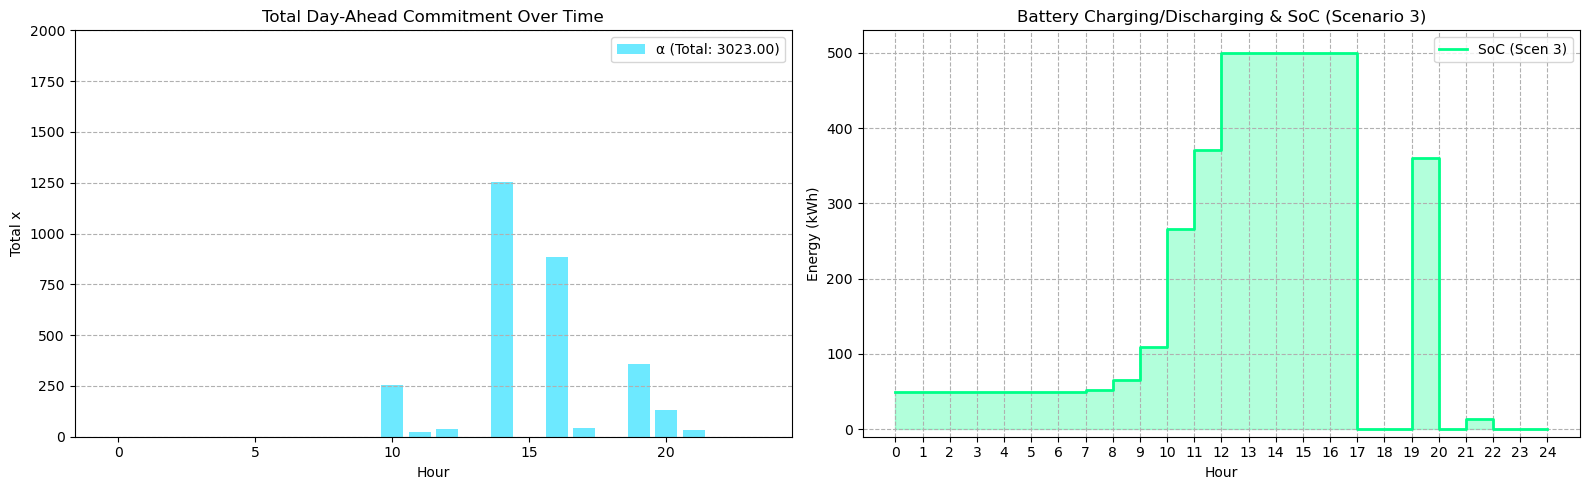

DA Profit      = 471718.39
RT Profit      = 1123798.26
Penalty Cost   = 4078.34
Total Profit   = 1591438.31, Objective Val  = 1591438.31


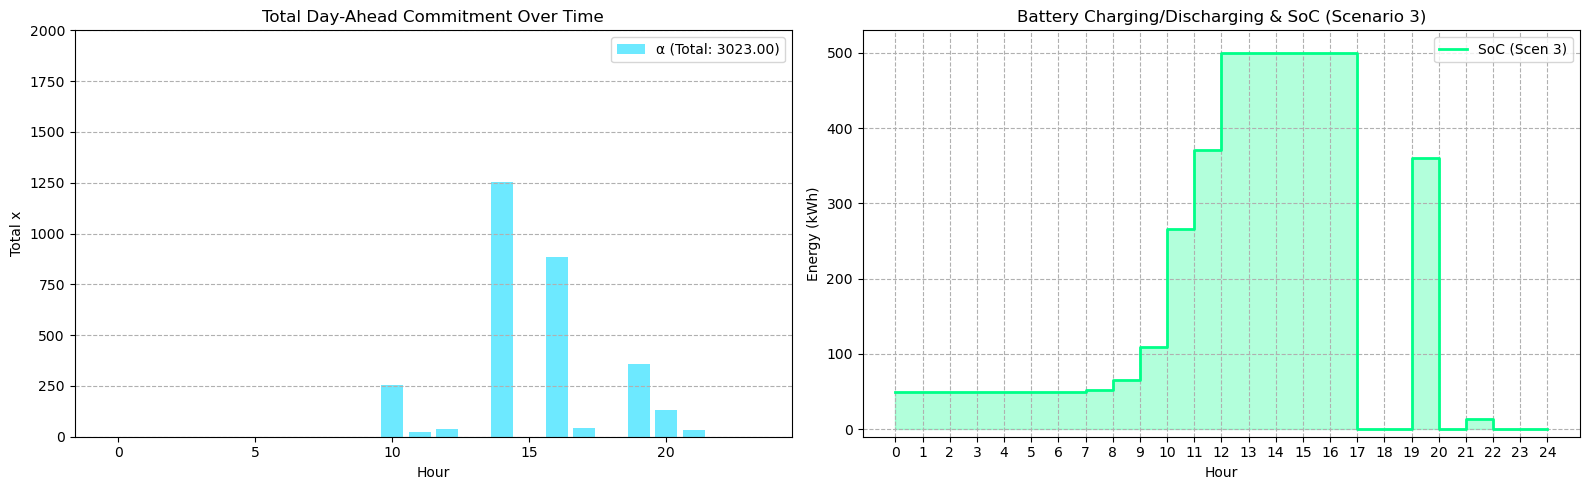

In [5]:
plot_summary(agg, K, P_DA, P_RT, P_PN, agg_a_vals, agg_bp_vals, agg_bm_vals, agg_g_vals, s=3)
plot_summary(set, K, P_DA, P_RT, P_PN, a_vals, bp_vals, bm_vals, g_vals, s=3)

In [6]:
for s, t, i in product(range(S), range(T), range(I)):
    print(f"[i={i} t={t:02}, s={s:02} BEFORE]  "
          f"R={R[i, t, s]:.2f}, x={x_vals[i, t, s]:.2f}, "
          f"y⁺={yp_vals[i, t, s]:.2f}, y⁻={ym_vals[i, t, s]:.2f}, "
          f"zᶜ={zc_vals[i, t, s]:.2f}, zᴰ={zd_vals[i, t, s]:.2f}, "
          f"z={z_vals[i, t, s]:.2f}")
    
    print(f"[i={i} t={t:02}, s={s:02} SET(-)]  "
          f"R={R[i, t, s]:.2f}, x={x_vals[i, t, s]:.2f}, "
          f"d⁺={dyp_vals[i, t, s]:.2f}, d⁻={dym_vals[i, t, s]:.2f}, "
          f"dᶜ={dzc_p_vals[i, t, s]:.2f}, dᴰ={dzd_p_vals[i, t, s]:.2f}, "
          f"z={z_vals[i, t, s]:.2f}")
    
    print(f"[i={i} t={t:02}, s={s:02} SET(+)]  "
          f"R={R[i, t, s]:.2f}, x={x_vals[i, t, s]:.2f}, "
          f"d⁺= -X-, d⁻= -X-,",
          f"dᶜ={dzc_m_vals[i, t, s]:.2f}, dᴰ={dzd_m_vals[i, t, s]:.2f}, "
          f"z={z_vals[i, t, s]:.2f}")

    print(f"[i={i} t={t:02}, s={s:02} AFTER ]  "
          f"R={R[i, t, s]:.2f}, x={x_vals[i, t, s]:.2f}, "
          f"e⁺={ep_vals[i, t, s]:.2f}, e⁻={em_vals[i, t, s]:.2f}, "
          f"eᶜ={ec_vals[i, t, s]:.2f}, eᴰ={ed_vals[i, t, s]:.2f}, "
          f"z={z_vals[i, t, s]:.2f}")
    print()

[i=0 t=00, s=00 BEFORE]  R=0.00, x=0.00, y⁺=0.00, y⁻=0.00, zᶜ=0.00, zᴰ=0.00, z=10.00
[i=0 t=00, s=00 SET(-)]  R=0.00, x=0.00, d⁺=0.00, d⁻=0.00, dᶜ=0.00, dᴰ=0.00, z=10.00
[i=0 t=00, s=00 SET(+)]  R=0.00, x=0.00, d⁺= -X-, d⁻= -X-, dᶜ=0.00, dᴰ=0.00, z=10.00
[i=0 t=00, s=00 AFTER ]  R=0.00, x=0.00, e⁺=0.00, e⁻=0.00, eᶜ=0.00, eᴰ=0.00, z=10.00

[i=1 t=00, s=00 BEFORE]  R=0.00, x=0.00, y⁺=0.00, y⁻=0.00, zᶜ=0.00, zᴰ=0.00, z=10.00
[i=1 t=00, s=00 SET(-)]  R=0.00, x=0.00, d⁺=0.00, d⁻=0.00, dᶜ=0.00, dᴰ=0.00, z=10.00
[i=1 t=00, s=00 SET(+)]  R=0.00, x=0.00, d⁺= -X-, d⁻= -X-, dᶜ=0.00, dᴰ=0.00, z=10.00
[i=1 t=00, s=00 AFTER ]  R=0.00, x=0.00, e⁺=0.00, e⁻=0.00, eᶜ=0.00, eᴰ=0.00, z=10.00

[i=2 t=00, s=00 BEFORE]  R=0.00, x=0.00, y⁺=0.00, y⁻=0.00, zᶜ=0.00, zᴰ=0.00, z=10.00
[i=2 t=00, s=00 SET(-)]  R=0.00, x=0.00, d⁺=0.00, d⁻=0.00, dᶜ=0.00, dᴰ=0.00, z=10.00
[i=2 t=00, s=00 SET(+)]  R=0.00, x=0.00, d⁺= -X-, d⁻= -X-, dᶜ=0.00, dᴰ=0.00, z=10.00
[i=2 t=00, s=00 AFTER ]  R=0.00, x=0.00, e⁺=0.00, e⁻=0.00, eᶜ=0

In [ ]:
for s, t in product(range(S), range(T)):
    for j in range(I):
        if(dzd_m_vals[j, t, s] > 0):
            for i in range(I): 
                print(f"[i={i} t={t:02}, s={s:02} BEFORE]  "
                    f"R={R[i, t, s]:.2f}, x={x_vals[i, t, s]:.2f}, "
                    f"y⁺={yp_vals[i, t, s]:.2f}, y⁻={ym_vals[i, t, s]:.2f}, "
                    f"zᶜ={zc_vals[i, t, s]:.2f}, zᴰ={zd_vals[i, t, s]:.2f}, "
                    f"z={z_vals[i, t, s]:.2f}")
                
                print(f"[i={i}, t={t:02}, s={s:02} SET(-)]  "
                    f"R={R[i, t, s]:.2f}, x={x_vals[i, t, s]:.2f}, "
                    f"d⁺={dyp_vals[i, t, s]:.2f}, d⁻={dym_vals[i, t, s]:.2f}, "
                    f"dᶜ={dzc_p_vals[i, t, s]:.2f}, dᴰ={dzd_p_vals[i, t, s]:.2f}, "
                    f"z={z_vals[i, t, s]:.2f}")
                
                print(f"[i={i} t={t:02}, s={s:02} SET(+)]  "
                    f"R={R[i, t, s]:.2f}, x={x_vals[i, t, s]:.2f}, "
                    f"d⁺= -X-, d⁻= -X-,",
                    f"dᶜ={dzc_m_vals[i, t, s]:.2f}, dᴰ={dzd_m_vals[i, t, s]:.2f}, "
                    f"z={z_vals[i, t, s]:.2f}")

                print(f"[i={i} t={t:02}, s={s:02} AFTER ]  "
                    f"R={R[i, t, s]:.2f}, x={x_vals[i, t, s]:.2f}, "
                    f"e⁺={ep_vals[i, t, s]:.2f}, e⁻={em_vals[i, t, s]:.2f}, "
                    f"eᶜ={ec_vals[i, t, s]:.2f}, eᴰ={ed_vals[i, t, s]:.2f}, "
                    f"z={z_vals[i, t, s]:.2f}")
                print()
            break

[i=0 t=14, s=00 BEFORE]  R=84.00, x=228.67, y⁺=0.00, y⁻=44.67, zᶜ=0.00, zᴰ=100.00, z=100.00
[i=0, t=14, s=00 SET(-)]  R=84.00, x=228.67, d⁺=0.00, d⁻=44.67, dᶜ=0.00, dᴰ=0.00, z=100.00
[i=0 t=14, s=00 SET(+)]  R=84.00, x=228.67, d⁺= -X-, d⁻= -X-, dᶜ=0.00, dᴰ=0.00, z=100.00
[i=0 t=14, s=00 AFTER ]  R=84.00, x=228.67, e⁺=0.00, e⁻=0.00, eᶜ=0.00, eᴰ=100.00, z=100.00

[i=1 t=14, s=00 BEFORE]  R=140.00, x=305.00, y⁺=0.00, y⁻=65.00, zᶜ=0.00, zᴰ=100.00, z=100.00
[i=1, t=14, s=00 SET(-)]  R=140.00, x=305.00, d⁺=0.00, d⁻=65.00, dᶜ=0.00, dᴰ=0.00, z=100.00
[i=1 t=14, s=00 SET(+)]  R=140.00, x=305.00, d⁺= -X-, d⁻= -X-, dᶜ=0.00, dᴰ=0.00, z=100.00
[i=1 t=14, s=00 AFTER ]  R=140.00, x=305.00, e⁺=0.00, e⁻=0.00, eᶜ=0.00, eᴰ=100.00, z=100.00

[i=2 t=14, s=00 BEFORE]  R=204.00, x=413.67, y⁺=0.00, y⁻=129.67, zᶜ=0.00, zᴰ=80.00, z=100.00
[i=2, t=14, s=00 SET(-)]  R=204.00, x=413.67, d⁺=0.00, d⁻=129.67, dᶜ=0.00, dᴰ=0.00, z=100.00
[i=2 t=14, s=00 SET(+)]  R=204.00, x=413.67, d⁺= -X-, d⁻= -X-, dᶜ=0.00, dᴰ=0.00, z